<a href="https://colab.research.google.com/github/dptru10/Materials_Informatics_Demos/blob/main/FeaturizeOptimizeCitrine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created as a tutorial for the Argonne Applied AI Speaker Series, by Dennis Trujillo

Install packages...

In [ ]:
!pip install -q forestci

In [ ]:
!pip install -q automatminer

     |████████████████████████████████| 463 kB 4.4 MB/s 
     |████████████████████████████████| 265 kB 24.7 MB/s 
     |████████████████████████████████| 6.8 MB 37.9 MB/s 
     |████████████████████████████████| 7.1 MB 16.3 MB/s 
     |████████████████████████████████| 2.6 MB 23.6 MB/s 
     |████████████████████████████████| 896 kB 41.8 MB/s 
     |████████████████████████████████| 209 kB 43.2 MB/s 
     |████████████████████████████████| 65 kB 3.1 MB/s 
     |████████████████████████████████| 109 kB 44.5 MB/s 
     |████████████████████████████████| 47 kB 3.4 MB/s 
     |████████████████████████████████| 325 kB 33.9 MB/s 
     |████████████████████████████████| 160 kB 46.7 MB/s 
     |████████████████████████████████| 546 kB 34.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.22

In [ ]:
!pip install -q matminer

Load matbench dataset for modelling

In [ ]:
import pandas as pd
import numpy as np
from matminer.datasets import load_dataset

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
df = load_dataset("matbench_steels")

Fetching matbench_steels.json.gz from https://ndownloader.figshare.com/files/17476040 to /usr/local/lib/python3.7/dist-packages/matminer/datasets/matbench_steels.json.gz


In [ ]:
df.columns

Index(['composition', 'yield strength'], dtype='object')

In [ ]:
endpoint='yield strength'
units = 'MPa'

Featurization, data cleaning and removal of highly correlated descriptors via Automatminer

In [ ]:
from automatminer import AutoFeaturizer,DataCleaner,FeatureReducer, TPOTAdaptor

autofeaturizer = AutoFeaturizer(preset="debug",n_jobs=4)
featurized = autofeaturizer.fit_transform(df,target=endpoint)

cleaner = DataCleaner(max_na_frac=0.05)
cleaned = cleaner.fit_transform(featurized,target=endpoint)

reducer = FeatureReducer(reducers=('corr',))
reduced = reducer.fit_transform(cleaned,target=endpoint)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and w

2022-06-03 18:38:38 INFO     AutoFeaturizer: Starting fitting.
2022-06-03 18:38:38 INFO     AutoFeaturizer: Compositions detected as strings. Attempting conversion to Composition objects...


StrToComposition: 100%|██████████| 312/312 [00:00<00:00, 1267.59it/s]


2022-06-03 18:38:39 INFO     AutoFeaturizer: Guessing oxidation states of compositions, as they were not present in input.


CompositionToOxidComposition: 100%|██████████| 312/312 [00:03<00:00, 87.59it/s]


2022-06-03 18:38:43 INFO     AutoFeaturizer: Featurizer type structure not in the dataframe to be fitted. Skipping...
2022-06-03 18:38:43 INFO     AutoFeaturizer: Featurizer type bandstructure not in the dataframe to be fitted. Skipping...
2022-06-03 18:38:43 INFO     AutoFeaturizer: Featurizer type dos not in the dataframe to be fitted. Skipping...
2022-06-03 18:38:43 INFO     AutoFeaturizer: Finished fitting.
2022-06-03 18:38:43 INFO     AutoFeaturizer: Starting transforming.
2022-06-03 18:38:43 INFO     AutoFeaturizer: Featurizing with ElementProperty.


ElementProperty: 100%|██████████| 312/312 [00:01<00:00, 184.02it/s]


2022-06-03 18:38:45 INFO     AutoFeaturizer: Featurizer type structure not in the dataframe. Skipping...
2022-06-03 18:38:45 INFO     AutoFeaturizer: Featurizer type bandstructure not in the dataframe. Skipping...
2022-06-03 18:38:45 INFO     AutoFeaturizer: Featurizer type dos not in the dataframe. Skipping...
2022-06-03 18:38:45 INFO     AutoFeaturizer: Finished transforming.
2022-06-03 18:38:45 INFO     DataCleaner: Starting fitting.
2022-06-03 18:38:45 INFO     DataCleaner: Cleaning with respect to samples with sample na_method 'drop'
2022-06-03 18:38:45 INFO     DataCleaner: Replacing infinite values with nan for easier screening.
2022-06-03 18:38:45 INFO     DataCleaner: Before handling na: 312 samples, 133 features
2022-06-03 18:38:45 INFO     DataCleaner: 0 samples did not have target values. They were dropped.
2022-06-03 18:38:45 INFO     DataCleaner: Handling feature na by max na threshold of 0.05 with method 'drop'.
2022-06-03 18:38:45 INFO     DataCleaner: After handling na

Labeling of potential outliers w/isolation forest

In [ ]:
from sklearn.ensemble import IsolationForest

isolated_forest=IsolationForest(n_estimators=400, n_jobs=-1, random_state=2, bootstrap=True)
isolated_forest.fit(reduced)
predicted = isolated_forest.predict(reduced)

In [ ]:
outlier_indices = []
inlier_indices  = []
i = 0
for prediction in predicted:
  if prediction == -1:
    outlier_indices.append(i)
  else: 
    inlier_indices.append(i)
  i = i + 1
print("outliers (%.2f), inliers (%.2f)" %(len(outlier_indices)/len(predicted),len(inlier_indices)/len(predicted)))

outliers (0.22), inliers (0.78)


Print a few examples of outliers discovered, (no particular order) 

In [ ]:
print(df['composition'].iloc[outlier_indices].head(n=5))

0    Fe0.620C0.000953Mn0.000521Si0.00102Cr0.000110N...
1    Fe0.623C0.00854Mn0.000104Si0.000203Cr0.147Ni0....
2    Fe0.625Mn0.000102Si0.000200Cr0.0936Ni0.129Mo0....
4    Fe0.636C0.000474Mn0.000518Si0.00101Cr0.000109N...
6    Fe0.644Mn0.000521Si0.00102Cr0.000110Ni0.177Mo0...
Name: composition, dtype: object


Visualization of outliers in a reduced feature space (pca vs. t-sne)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
p_features = pca.fit_transform(reduced)

We observe some clustering of data points w/inliers relatively closely bunched vs. outliers distributed diffusely and separate from the weakly clustered inliers.

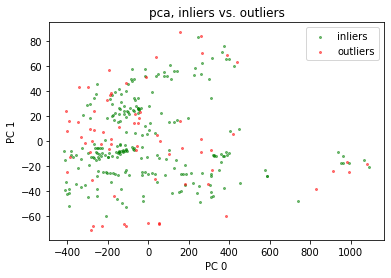

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors

plt.figure() 
plt.scatter(p_features[inlier_indices, 0], p_features[inlier_indices, 1], s=4, lw=1, label="inliers", c="green", alpha=0.5)
plt.scatter(p_features[outlier_indices, 0], p_features[outlier_indices, 1], s=4, lw=1, label="outliers", c="red", alpha=0.5)
plt.xlabel('PC 0')
plt.ylabel('PC 1')
plt.legend()
plt.title('pca, inliers vs. outliers')
plt.show()

In [ ]:
from sklearn.manifold import TSNE
t_features = TSNE(n_components=2,init='pca').fit_transform(reduced)

Similar behavior is observed in the t-sne graph, although the separating between inliers and outliers is less visible compared to the PCA plot above.

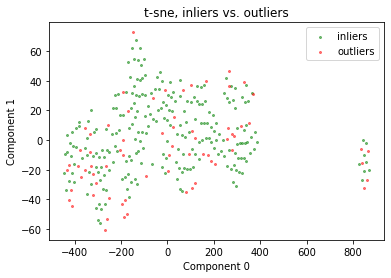

In [ ]:
plt.figure() 
plt.scatter(t_features[inlier_indices, 0], t_features[inlier_indices, 1], s=4, lw=1, label="inliers", c="green", alpha=0.5)
plt.scatter(t_features[outlier_indices, 0], t_features[outlier_indices, 1], s=4, lw=1, label="outliers", c="red", alpha=0.5)
plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.legend()
plt.title('t-sne, inliers vs. outliers')
plt.show()

In [ ]:
X = reduced.loc[:,reduced.columns != endpoint] 
Y = reduced[endpoint]

Split Featurized Data into train-test sets w/80-20 split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=2)


In [ ]:
from pandas.core.common import random_state
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True]#,False]
# Create the random grid
tuned_parameters = {'n_estimators': n_estimators,'max_features': max_features,'max_depth': max_depth,
                'min_samples_split': min_samples_split,'min_samples_leaf': min_samples_leaf,'bootstrap': bootstrap}

If desired we can define our own scorer to optimize the hyperparameter space

In [ ]:
def mse(y_true,y_pred): 
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.power(y_true - y_pred,2).mean()

In [ ]:
from sklearn.metrics import make_scorer  
mse_scorer          = make_scorer(mse, greater_is_better=False)

We optimize the hyperparameter space w/the Minimized MSE of the yield strength considered as the objective function

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor


score = 'neg_mean_squared_error' #mse_scorer

forest = RandomizedSearchCV(RandomForestRegressor(random_state=1),tuned_parameters,verbose=10,cv=5,n_jobs=-1,scoring=score)
    
forest.fit(X_train, y_train)

print("Best parameters set found on development set:")    
print()
print(str(forest.best_params_))
print()
print('Score:')
print(str(forest.best_score_))
print()
print('done!...')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.0s finished


Best parameters set found on development set:

{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': True}

Score:
-28193.156472299084

done!...


Using the best hyperparameter set found we fit a RandomForestRegressor and list the top 10 most important features as determined by the RFR feature importance

In [ ]:
#use best hyperparams and determine feature importance
params = dict(forest.best_params_)
forest_imp = RandomForestRegressor(**params)
forest_imp.fit(X,Y)

importances = forest_imp.feature_importances_
indices = np.argsort(importances)[::-1]

In [ ]:
model_train = forest_imp.predict(X_train)
model_test  = forest_imp.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

r2_score_train=r2_score(y_train,model_train)
mse_score_train=mean_squared_error(y_train,model_train)
mae_score_train=mean_absolute_error(y_train,model_train)
rmse_score_train=np.sqrt(mse_score_train)

r2_score_test=r2_score(y_test,model_test)
mse_score_test=mean_squared_error(y_test,model_test)
mae_score_test=mean_absolute_error(y_test,model_test)
rmse_score_test=np.sqrt(mse_score_test)

In [ ]:
print("Test set scores:")
print("R2: %.2f" %r2_score_test)
print("MSE: %.2f" %mse_score_test)
print("MAE: %.2f" %mae_score_test)
print("RMSE: %.2f" %rmse_score_test)

Test set scores:
R2: 0.97
MSE: 3127.08
MAE: 37.21
RMSE: 55.92


In [ ]:
print("Training set scores:")
print("R2: %.2f" %r2_score_train)
print("MSE: %.2f" %mse_score_train)
print("MAE: %.2f" %mae_score_train)
print("RMSE: %.2f" %rmse_score_train)

Training set scores:
R2: 0.93
MSE: 6151.70
MAE: 48.18
RMSE: 78.43


In [ ]:
print("Feature ranking:")
features = X.columns 
ranked_features=[]
n_features = 10
for f in range(n_features):#X.shape[1]):
  ranked_features.append(features[indices[f]])
  print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. MagpieData avg_dev NUnfilled (0.379539)
2. MagpieData mean Electronegativity (0.059223)
3. MagpieData avg_dev GSbandgap (0.057412)
4. MagpieData avg_dev GSmagmom (0.050731)
5. MagpieData mean GSmagmom (0.048660)
6. MagpieData mean SpaceGroupNumber (0.045409)
7. MagpieData avg_dev NdUnfilled (0.042899)
8. MagpieData mean Column (0.031077)
9. MagpieData avg_dev NsUnfilled (0.026731)
10. MagpieData mean MeltingT (0.026113)


We plot the predicted vs. true values in a 2D histogram qualitatively show the deviation from the true value and the density of data points in a region

This first figure represents the training set 

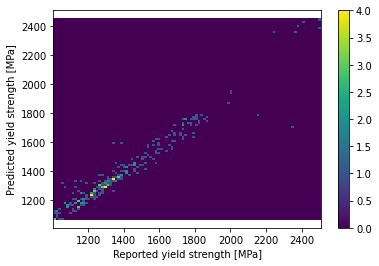

In [ ]:
#plot figures
plt.figure()
plt.hist2d(x=y_train,y=model_train,bins=100,norm=colors.Normalize())   
plt.axis([np.min(Y),np.max(Y),np.min(Y),np.max(Y)])
plt.colorbar() 
plt.xlabel('Reported %s [%s]' %(endpoint,units))
plt.ylabel('Predicted %s [%s]' %(endpoint,units))
plt.show()

And this one represents the test set

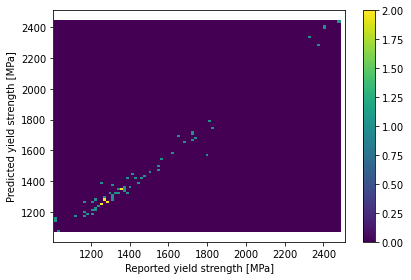

In [ ]:
plt.figure()
plt.hist2d(x=y_test,y=model_test,bins=100,norm=colors.Normalize())
plt.axis([np.min(Y),np.max(Y),np.min(Y),np.max(Y)])
plt.colorbar() 
plt.xlabel('Reported %s [%s]' %(endpoint,units))
plt.ylabel('Predicted %s [%s]' %(endpoint,units))
plt.tight_layout()
plt.show()

Using a random forest it is possible to determine the variance in the model and utilize this to plot the uncertainity

Likewise we can determine the sample which exhibits the Maximum Uncertainty (MU), Maximum Expected Improvement (MEI) and Maximum Likelihood of Improvement utilizing the RFR model applied to the test set and the associated uncertainties.

This methodology is inspired by the following paper, https://link.springer.com/article/10.1007/s40192-017-0098-z 

In [ ]:
import forestci as fci

v_ij = fci.random_forest_error(forest_imp, np.array(X_train), np.array(X_test), calibrate=False)
mu_idx  = np.argmax(np.abs(v_ij))
mei_idx = np.argmax(model_test)
mli_idx = np.argsort(model_test + np.sqrt(np.abs(v_ij)))[-1]


Failed to import duecredit due to No module named 'duecredit'


We see that for regions w/many data points the uncertainty is low and higher for regions w/fewer data points (upper right) 

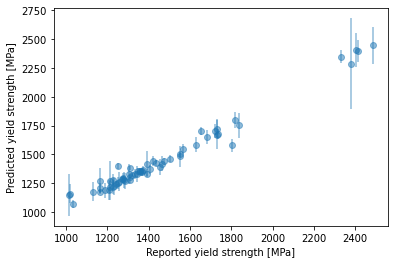

In [ ]:
plt.figure() 
plt.xlabel('Reported %s [%s]' %(endpoint,units))
plt.ylabel('Predicted %s [%s]' %(endpoint,units))
plt.errorbar(y_test, model_test, yerr=np.sqrt(np.abs(v_ij)), fmt='o', alpha=0.5)
plt.show()

We see that the sample with the Max. Uncertainty (MU, red star) has the largest error bar as expected, and the sample w/the Max. Expected Improvement (MEI, green star) exhibits the largest predicted fatigue strength. The sample w/the Max. Likelihood of Improvement (MLI, yellow star) exhibits both a high predicted value and relatively high uncertainty.

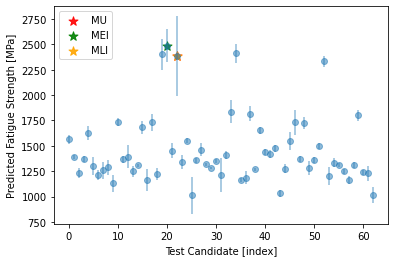

In [ ]:
plt.figure() 
plt.errorbar(range(len(y_test)), y_test, yerr=np.sqrt(np.abs(v_ij)), fmt='o',alpha=0.5)
plt.scatter(mu_idx,np.array(y_test)[mu_idx],color='red',marker='*',s=90,alpha=0.9,label='MU')
plt.scatter(mei_idx,np.array(y_test)[mei_idx],color='green',marker='*',s=90,alpha=0.9,label='MEI')
plt.scatter(mli_idx,np.array(y_test)[mli_idx],color='orange',marker='*',s=90,alpha=0.9,label='MLI')
plt.xlabel("Test Candidate [index]")
plt.ylabel("Predicted Fatigue Strength [MPa]")
plt.legend(loc="upper left")
plt.show()

Printing the composition of these three samples we see that they all contain Fe, Cr, Co, Al, and Ti as components, w/Cr being the second most prevalent in composition amongst the shared elements in these compositions after Fe.

In [ ]:
print("Composition of sample with Maximum Uncertainty:\n%s" %str(df['composition'].iloc[y_test.index[mu_idx]]))

Composition of sample with Maximum Uncertainty:
Fe0.667C0.000477Mn0.000522Si0.00102Cr0.000110Ni0.171Mo0.0233V0.000113Nb0.0000617Co0.115Al0.00361Ti0.0184


In [ ]:
print("Composition of sample with Maximum Expected Improvement:\n%s" %str(df['composition'].iloc[y_test.index[mei_idx]]))

Composition of sample with Maximum Expected Improvement:
Fe0.634C0.000478Mn0.000523Si0.00102Cr0.000111Ni0.173Mo0.0237V0.000113Nb0.0000619Co0.146Al0.00277Ti0.0176


In [ ]:
print("Composition of sample with Maximum Likelihood of Improvement:\n%s" %str(df['composition'].iloc[y_test.index[mli_idx]]))

Composition of sample with Maximum Likelihood of Improvement:
Fe0.667C0.000477Mn0.000522Si0.00102Cr0.000110Ni0.171Mo0.0233V0.000113Nb0.0000617Co0.115Al0.00361Ti0.0184
